<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
## Task
This report will analyse the methodology used to complete assignment 2 of the course Machine Learning (COSC2673/2793). The objective of the assignment is to develop a machine-learning system that can classify traffic sign images.

The project is divided into two tasks:


*   Classify images according to the shape of the given image.
*    Classify images according to type.



## Approach
Our goal is to be able to identify the best possible machine-learning algorithm to generate a model that can reliably and consistently predict whether the type of traffic sign is based on image recognition.

# Reading Data

In [23]:
from google.colab import drive
import os
import csv
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2

In [25]:
!cp -r "/content/drive/MyDrive/Assignment2" .

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Assignment2/trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

create a type csv

In [80]:
root_dir = '/content/trafficsigns_dataset'

output_csv = '/content/drive/My Drive/Assignment2/shape.csv'

class_mapping = {}

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class', 'encoded_class'])

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                class_name = os.path.basename(os.path.dirname(root))
                if class_name not in class_mapping:
                    class_mapping[class_name] = len(class_mapping)
                image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
                resized_image = cv2.resize(image, (28, 28))
                resized_image = np.expand_dims(resized_image, axis=-1)

                writer.writerow([full_path, class_name, class_mapping[class_name]])

print("CSV file has been created successfully.")

CSV file has been created successfully.


Train type dataset

create a type csv and encoding classes

In [81]:
output_csv = '/content/drive/My Drive/Assignment2/type.csv'

class_mapping = {}

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class', 'encoded_class'])

    for root, dirs, files in os.walk(root_dir):
        for file_name in files:
            if file_name.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file_name)
                class_name = os.path.basename(root)
                if class_name not in class_mapping:
                    class_mapping[class_name] = len(class_mapping)
                image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
                resized_image = cv2.resize(image, (28, 28))
                resized_image = np.expand_dims(resized_image, axis=-1)

                writer.writerow([full_path, class_name, class_mapping[class_name]])

print("CSV file has been created successfully.")


CSV file has been created successfully.


In [83]:

type_df = pd.read_csv('/content/drive/My Drive/Assignment2/type.csv')
shape_df = pd.read_csv('/content/drive/My Drive/Assignment2/shape.csv')

X_shape_train, X_shape_val, X_shape_test = [], [], []
y_shape_train, y_shape_val, y_shape_test = [], [], []
X_type_train, X_type_val, X_type_test = [], [], []
y_type_train, y_type_val, y_type_test = [], [], []

shape_groups = shape_df.groupby('encoded_class')
type_groups = type_df.groupby('encoded_class')

for label, group in shape_groups:
    X_train, X_temp, y_train, y_temp = train_test_split(group[['image_path', 'encoded_class']], group['encoded_class'], test_size=0.2, stratify=group['encoded_class'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)
    X_shape_train.extend(X_train.values)
    X_shape_val.extend(X_val.values)
    X_shape_test.extend(X_test.values)
    y_shape_train.extend(y_train)
    y_shape_val.extend(y_val)
    y_shape_test.extend(y_test)

for label, group in type_groups:
    X_train, X_temp, y_train, y_temp = train_test_split(group[['image_path', 'encoded_class']], group['encoded_class'], test_size=0.2, stratify=group['encoded_class'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)
    X_type_train.extend(X_train.values)
    X_type_val.extend(X_val.values)
    X_type_test.extend(X_test.values)
    y_type_train.extend(y_train)
    y_type_val.extend(y_val)
    y_type_test.extend(y_test)

X_shape_train = pd.DataFrame(X_shape_train, columns=['image_path', 'encoded_class'])
X_shape_val = pd.DataFrame(X_shape_val, columns=['image_path', 'encoded_class'])
X_shape_test = pd.DataFrame(X_shape_test, columns=['image_path', 'encoded_class'])

y_shape_train = np.array(y_shape_train)
y_shape_val = np.array(y_shape_val)
y_shape_test = np.array(y_shape_test)

X_type_train = pd.DataFrame(X_type_train, columns=['image_path', 'encoded_class'])
X_type_val = pd.DataFrame(X_type_val, columns=['image_path', 'encoded_class'])
X_type_test = pd.DataFrame(X_type_test, columns=['image_path', 'encoded_class'])

y_type_train = np.array(y_type_train)
y_type_val = np.array(y_type_val)
y_type_test = np.array(y_type_test)


print("Shape of X_shape_train:", X_shape_train.shape)
print("Shape of X_shape_val:", X_shape_val.shape)
print("Shape of X_shape_test:", X_shape_test.shape)
print("Shape of y_shape_train:", y_shape_train.shape)
print("Shape of y_shape_val:", y_shape_val.shape)
print("Shape of y_shape_test:", y_shape_test.shape)
print("\nShape of X_type_train:", X_type_train.shape)
print("Shape of X_type_val:", X_type_val.shape)
print("Shape of X_type_test:", X_type_test.shape)
print("Shape of y_type_train:", y_type_train.shape)
print("Shape of y_type_val:", y_type_val.shape)
print("Shape of y_type_test:", y_type_test.shape)


Shape of X_shape_train: (2957, 2)
Shape of X_shape_val: (554, 2)
Shape of X_shape_test: (188, 2)
Shape of y_shape_train: (2957,)
Shape of y_shape_val: (554,)
Shape of y_shape_test: (188,)

Shape of X_type_train: (2954, 2)
Shape of X_type_val: (553, 2)
Shape of X_type_test: (192, 2)
Shape of y_type_train: (2954,)
Shape of y_type_val: (553,)
Shape of y_type_test: (192,)


# EDA

# Model development

## Base Model

In [109]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [110]:
INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 5

In [111]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.15.0'

In [121]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [122]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               200960    
                                                                 
 dense_15 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 202245 (790.02 KB)
Trainable params: 202245 (790.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


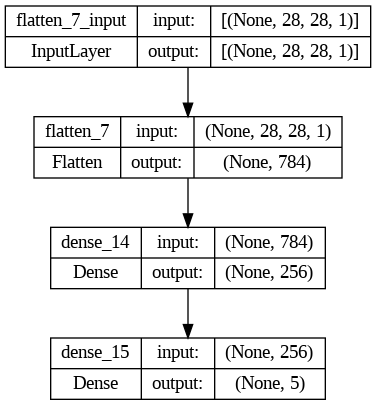

In [123]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [124]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [125]:
X_shape_train['encoded_class'] = X_shape_train['encoded_class'].astype('str')
X_shape_val['encoded_class'] = X_shape_val['encoded_class'].astype('str')

X_type_train['encoded_class'] = X_type_train['encoded_class'].astype('str')
X_type_val['encoded_class'] = X_type_val['encoded_class'].astype('str')

print("Shape of X_shape_train:", X_shape_train.shape)
print("Shape of X_shape_val:", X_shape_val.shape)
print("Shape of X_shape_test:", X_shape_test.shape)
print("\nShape of X_type_train:", X_type_train.shape)
print("Shape of X_type_val:", X_type_val.shape)
print("Shape of X_type_test:", X_type_test.shape)

Shape of X_shape_train: (2957, 2)
Shape of X_shape_val: (554, 2)
Shape of X_shape_test: (188, 2)

Shape of X_type_train: (2954, 2)
Shape of X_type_val: (553, 2)
Shape of X_type_test: (192, 2)


#Shape prediction

In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Shape
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 20

train_generator = train_datagen.flow_from_dataframe(
        dataframe=X_shape_train,
        directory='./dataShape/train',
        x_col="image_path",
        y_col="encoded_class",
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=X_shape_val,
        directory='./dataShape/validation',
        x_col="image_path",
        y_col="encoded_class",
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

Found 2957 validated image filenames belonging to 5 classes.
Found 554 validated image filenames belonging to 5 classes.


In [127]:
import tensorflow as tf

model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [128]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


147/147 [==============================] - 2s 11ms/step - loss: 1.2577 - categorical_accuracy: 0.4780 - val_loss: 1.1886 - val_categorical_accuracy: 0.4778
Epoch 2/10
147/147 [==============================] - 2s 10ms/step - loss: 1.1400 - categorical_accuracy: 0.5325 - val_loss: 1.1110 - val_categorical_accuracy: 0.5407
Epoch 3/10
147/147 [==============================] - 2s 13ms/step - loss: 1.0651 - categorical_accuracy: 0.5819 - val_loss: 1.0446 - val_categorical_accuracy: 0.5722
Epoch 4/10
147/147 [==============================] - 2s 11ms/step - loss: 1.0011 - categorical_accuracy: 0.6258 - val_loss: 0.9895 - val_categorical_accuracy: 0.5778
Epoch 5/10
147/147 [==============================] - 1s 9ms/step - loss: 0.9392 - categorical_accuracy: 0.6701 - val_loss: 0.9363 - val_categorical_accuracy: 0.6778
Epoch 6/10
147/147 [==============================] - 1s 9ms/step - loss: 0.8881 - categorical_accuracy: 0.7031 - val_loss: 0.8814 - val_categorical_accuracy: 0.7259
Epoch 7/10


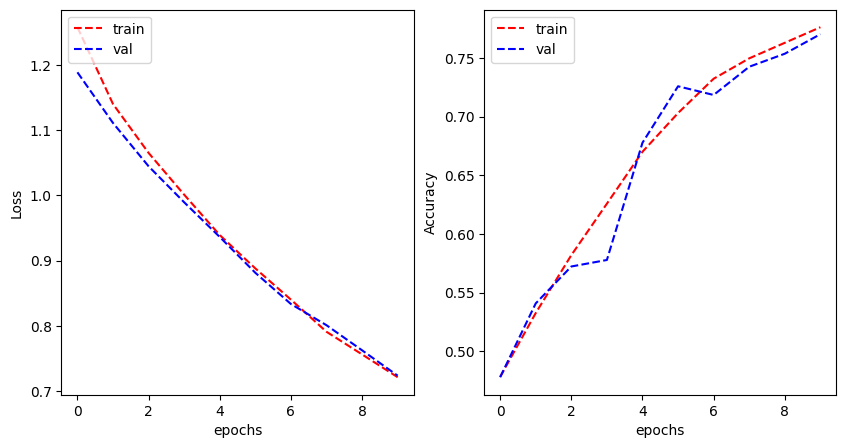

In [129]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [199]:
label_names = {'Square' : 0, 'Round' : 1, 'Hex' : 2, 'Diamond' : 3, 'Tringle' : 4 }

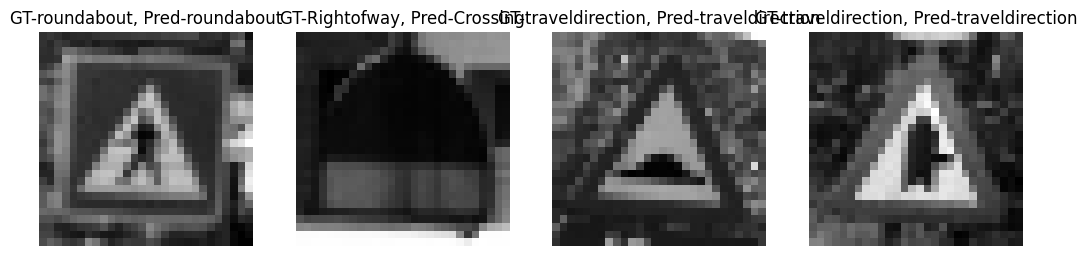

In [209]:
import matplotlib.pyplot as plt
import numpy as np

d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16, 4))
batches = 0

for x, y in train_generator:
    batches += 1
    y_hat = model.predict(x, verbose=0)
    x = np.squeeze(x[0])

    if batches < 5:
        plt.subplot(1, 5, batches)
        plt.imshow(x, cmap='gray')
        plt.title(f"GT-{d_inv[np.argmax(y[0])]}, Pred-{d_inv[np.argmax(y_hat[0])]}")
        plt.axis('off')
    else:
        break

plt.show()


#Type prediction

In [162]:

# Type
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 20

train_generator = train_datagen.flow_from_dataframe(
        dataframe=X_type_train,
        directory='./dataType/train',
        x_col="image_path",
        y_col="encoded_class",
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=X_type_val,
        directory='./dataType/validation',
        x_col="image_path",
        y_col="encoded_class",
        target_size=(28, 28),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

Found 2954 validated image filenames belonging to 16 classes.
Found 553 validated image filenames belonging to 16 classes.


In [167]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(16, activation='softmax')
])


In [168]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 5408)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               692352    
                                                                 
 dense_17 (Dense)            (None, 16)                2064      
                                                                 
Total params: 694736 (2.65 MB)
Trainable params: 694736 (2.65 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

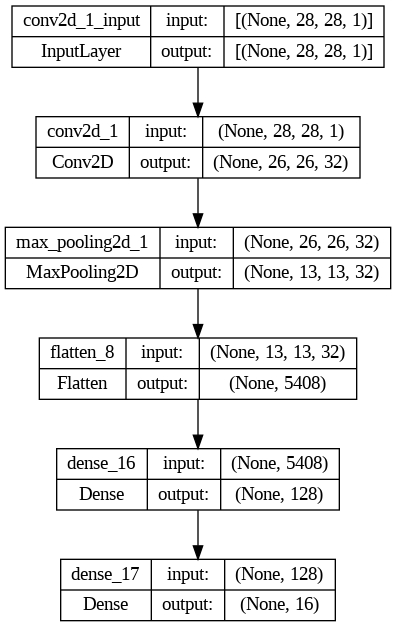

In [169]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [171]:
import tensorflow as tf

model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [202]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


147/147 [==============================] - 7s 38ms/step - loss: 2.4077 - categorical_accuracy: 0.2686 - val_loss: 2.0202 - val_categorical_accuracy: 0.4463
Epoch 2/10
147/147 [==============================] - 4s 28ms/step - loss: 1.6249 - categorical_accuracy: 0.5879 - val_loss: 1.2619 - val_categorical_accuracy: 0.6759
Epoch 3/10
147/147 [==============================] - 2s 16ms/step - loss: 1.0730 - categorical_accuracy: 0.7290 - val_loss: 1.0110 - val_categorical_accuracy: 0.7148
Epoch 4/10
147/147 [==============================] - 2s 16ms/step - loss: 0.8079 - categorical_accuracy: 0.7890 - val_loss: 0.6967 - val_categorical_accuracy: 0.8204
Epoch 5/10
147/147 [==============================] - 2s 16ms/step - loss: 0.6533 - categorical_accuracy: 0.8306 - val_loss: 0.7915 - val_categorical_accuracy: 0.7722
Epoch 6/10
147/147 [==============================] - 5s 31ms/step - loss: 0.5431 - categorical_accuracy: 0.8613 - val_loss: 0.5006 - val_categorical_accuracy: 0.8519
Epoch 7/1

In [180]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_type_train,  # استخدام X_type_train بدلاً من X_train
    directory='./data/train',  # تأكد من صحة المسار
    x_col='image_path',
    y_col='encoded_class',
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=20,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_type_val,  # استخدام X_type_val بدلاً من X_val
    directory='./data/validation',  # تأكد من صحة المسار
    x_col='image_path',
    y_col='encoded_class',
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=20,
    class_mode='categorical'
)


Found 2954 validated image filenames belonging to 16 classes.
Found 553 validated image filenames belonging to 16 classes.


In [204]:
import tensorflow as tf

model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


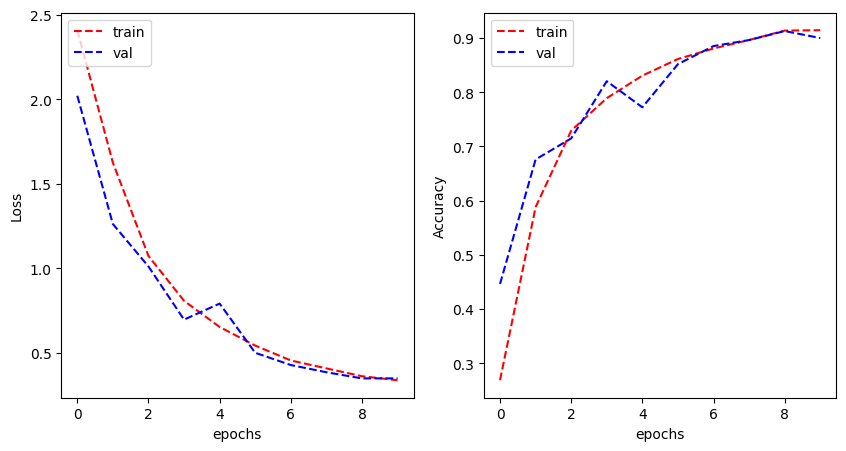

In [205]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [206]:
label_names = {'Landeed' : 0, 'Continue' : 1, 'Crossing' : 2, 'Parking' : 3, 'Bicycle' : 4 ,'Trafficdirective' : 5, 'Round' : 6, 'traveldirection' : 7, 'roundabout' : 8, 'speed' : 9,'noparking' : 10, 'limitedtraffic' : 11, 'Stop' : 12, 'Rightofway' : 13, 'Giveway' : 14  }

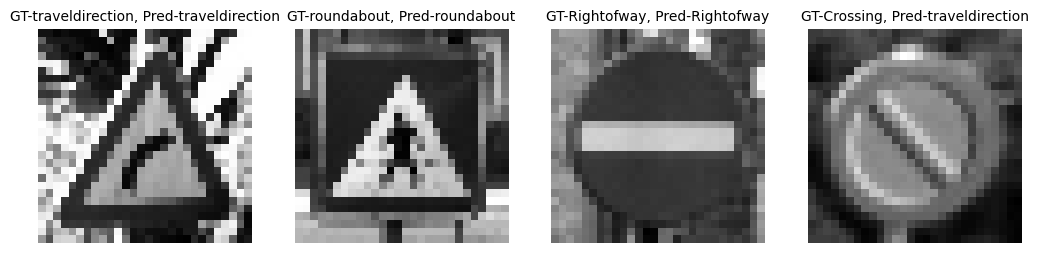

In [211]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16, 4))
batches = 0

for x, y in train_generator:
    batches += 1
    y_hat = model.predict(x, verbose=0)
    x = np.squeeze(x[0])

    if batches < 5:
        plt.subplot(1, 5, batches)
        plt.imshow(x, cmap='gray')
        plt.title(f"GT-{d_inv[np.argmax(y[0])]}, Pred-{d_inv[np.argmax(y_hat[0])]}", fontsize=10)
        plt.axis('off')
    else:
        break
plt.show()